In [1]:
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.stats as ss
import math
import random

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (12,8)

# Estimation Applications

We can use our estimation skillz to do some more stuff beyond estimating the population. 

### But First, Estimate a Population

We can keep estimating populations with our analytical distribution. First - we'll do another normal one, but we'll grab some extra data to investigate it a bit more along the way. 

Our simulator will be like last time, it'll take in the emperical statistics from our sample, run a bunch of trials for generating analytical sample datasets, total those results up for analysis, and return it back. 

In [2]:
#Simulate Normal - from last time
#
#Add a return to send back the means and the predictions. 
#
def simulateNormal(mu=0, sigma=1, n=100, m=10000, ciLow=5, ciHi=95):
    means = [] #List of all the means that are created. 
    preds = []
    for j in range(m): #Run m number of simulations. 
        xs = np.random.normal(mu, sigma, n) #Generate a normal dist based on emperical data. 
        xbar = np.mean(xs) #Take the mean of the dist above's values
        means.append(xbar) #Add to list. 
        preds.append(xs)
    cdf = thinkstats2.Cdf(means) #Make a CDF of the means of the analytical dist's
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi) #5th, 95th percentiles. 
    muList = [mu] * m
    stderr = mean_squared_error(means, muList, squared=False) #RMSE of how different the random analytical means are from the emp. mean. 
    return cdf, ci, stderr, means, preds

We'll add these error calculators, we'll use them later. 

In [3]:
def MeanError(estimates, actual):
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

In [4]:
def RMSE(estimates, actual):
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

#### Load Some Data - Using LogNormal Data

Here we'll use some real data, data that has already been transformed to help us. The log.annual.inc value is the income <b><i>after</i></b> it has been transformed. This takes it from its original lognormal format to a normal distribution, which we know how to analyze easily. 

In [5]:
#Load some data
df = pd.read_csv("data/loan_data.csv")
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [6]:
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


<h3>Warmup - Estimate Normal Distribution for Income</h3>

We are given the log.annual.inc, which is the income of the applicants, run through a log transformation. Take a look via a graph...

We can also plot the de-logged, or exponential transformed, income, which should be our orignal incomes. We should double check to see if it makes sense, and to see what it looks like. 

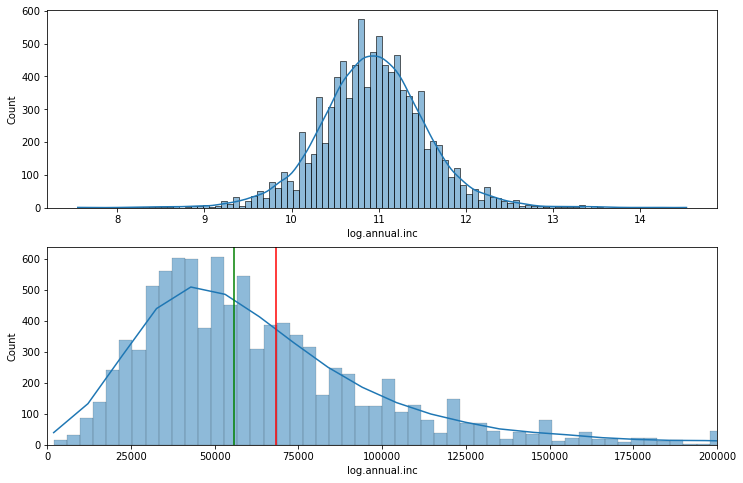

In [7]:
#Graph distribution of log income
thinkplot.PrePlot(2, 2, 1)
sns.histplot(df["log.annual.inc"], kde=True)
thinkplot.SubPlot(2)
sns.histplot(np.exp(df["log.annual.inc"]), kde=True).set(xlim=(0,200000))
plt.axvline(np.mean(np.exp(df["log.annual.inc"])), color="red")
plt.axvline(np.median(np.exp(df["log.annual.inc"])), color="green")
plt.ticklabel_format(style='plain', axis='x')
thinkplot.Config()

<h3>When lognormal is normal!</h3>

The log.annual.inc value looks really normal - estimate the income of the population as a whole. 

<b>Note:</b> this data is the income data, that has been transformed, with a log transformation. This is one example of some ways that we can use a transformation to make analysis easier. Transform the data into somehting that is easy to analyze, like a normal dist, do what you need to do, then transform in reverse to get raw data. 

The original distribution above could be analyzed directly via modelling it with a lognorm distribution, like we'll try below, but normal things are generally more simple, that's why this data was pretransformed. This is easier for lognorm stuff.  

#### Keep Working, Looking Backwards

Work with the data (already logged, the original format). First we'll do a little demonstration - the simulateNormal function also returns the "preds" value, which is the actual raw set of the predictions. This is the core of the estimations that we were doing before - we generate a bunch of "fake" distributions - each showing what we <b>expect</b> the distribution of the data to be like if it is actually following a normal distribution with the statistics (mean, standard deviation, and count) found in the emperical data. This plot draws each of those anticipated distributions at once, we can see that each one differs a little bit, but as more and more are drawn we can conclude a clear pattern. 

For the estimation before, we were taking the means of each of these distributions, and each of those is one prediction of the population mean. Our best estimate was the mean of those means. 

<b>Note:</b> play with the n and m values a little to draw different nubmers - the n value, or the sample size of the emperical data, will drastically impact the spread of the different sets of predictions. This should make sense - if we sample 10 people, their incomes may be distributed very randomly; if we sample 10,000 people, the true distribution of the data will outweigh those random low probability events. E.g. if you sample 10 Edmonton are residents for income, you might get 2 Oilers who make millions, which would make your income distribution look nothing like reality; this is unlikely, but definately possible. If you sample 10,000 people, maybe you still get 2 Oilers (the oilers are ~25 people out of ~1.3 million, so the odds of getting multiple of them is still extremely unlikely) but those 2 values will minorly impact 10,000 values while they will overwhelm 10 values. This is basically how sample size increases help with accuracy - though the differences are subtle, not massive differences with outliers, which may likely be filtered out anyway. 

##### Alternate Outliering - the Median

If we do encounter something like outliers messing up our data, one thing to potentially try is to take the power of the median and the normal distribution into our hands. We'll use two facts:
<ul>
<li> The median is less impacted by outliers. 
<li> In a true normal distribution, the mean and median will be equal. 
</ul>

What's the end result - we can try replacing the mean with the median if outliers make an outsized concern. This is a bit of a hack, yes, but we are changing our approach to target our goal. We wish to estimate the mean income of the population as a whole - if we run into a scenario that using the emperical mean causes our analytical distributions to mirror the real distribution worse, we can make a judgement call to sawap it. Things such as this are not uncommon, we don't want to generate 100% accurate stats from the emperical data, though that may be nice, we want to use that emperical data as a tool to estimate - if we need to alter it, we can. We are basically making an assertion that the median will be a better estimator than the mean - or it will introduce less error. 

Mean: 10.932117137800155  Median: 10.92888357


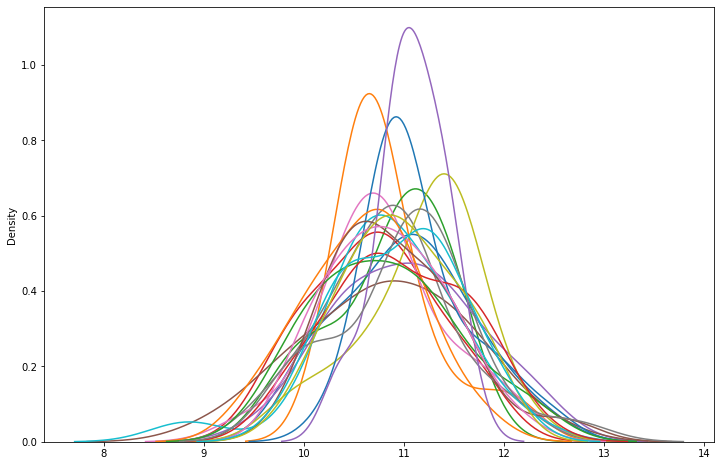

In [8]:
#Generate estimators for normal data. 
mu = df["log.annual.inc"].mean()
sig = df["log.annual.inc"].std()
n = df["log.annual.inc"].count()
med = df["log.annual.inc"].median()
print("Mean:",mu," Median:",med)

#Run Estimations. 
cdf, ci, stderr, means, preds = simulateNormal(mu=med, sigma=sig, n=20, m=20, ciLow=5, ciHi=95)

#Graph each of those predictions from above - 1000 originally. 
for i in range(len(preds)):
    sns.kdeplot(preds[i])

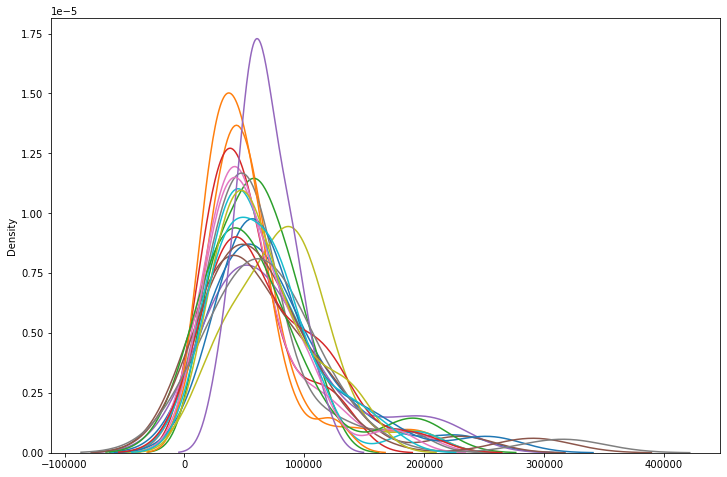

In [9]:
# With the log removed
for i in range(len(preds)):
    sns.kdeplot(np.exp(preds[i]))

##### What's This?

Each of those trial runs of the analytical distribution is slightly different, as we can see here. Each individual prediction varries, depending largely on:
<ul>
<li> The emperical sample size. 
<li> The closeness of the emperical/analytical distribution match. 
<li> The varriance in the data. 
</ul>

The better we get on those metrics, the less error there is in our projections, and the more accurately we can expect to estimate or predict. 

#### CDF of the Means

We are 90% confident that we are between the two CI limits. As a reminder, this CDF is made of the means of each of the distributions above - each line translates into one value, it's mean in the CDF data. 

(10.58579083597307, 11.143464992062425)

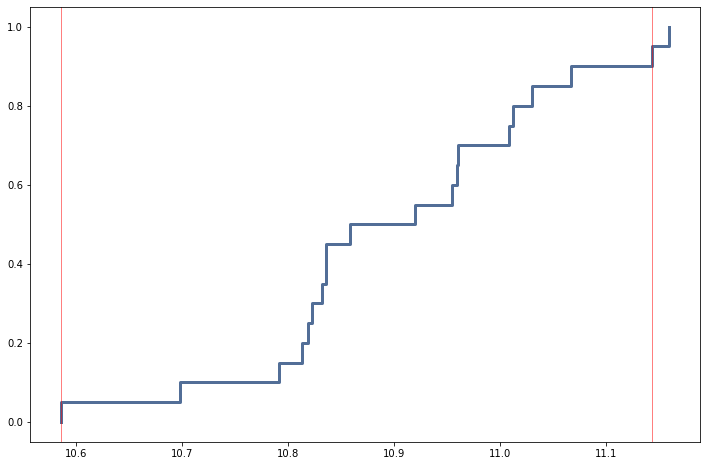

In [10]:
thinkplot.Cdf(cdf)
thinkplot.axvline(ci[0], color="red")
thinkplot.axvline(ci[1], color="red")
ci[0], ci[1]

#### Overall

Each random band up there is one prediction of the distribution of the population of income. I.E. each one is one execution of the "random" command that generates N variables according to the distribution. 

The means is taking the average of all of those above predicted distributions, then averaging them together. So that is estimating the mean of the population of income M times, graphed below.  

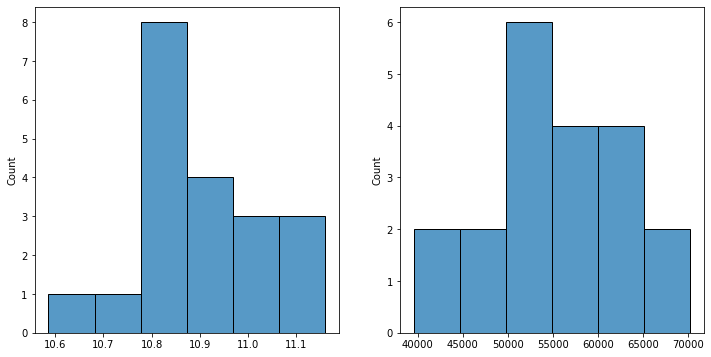

In [11]:
#Plot the means of the above distributions
#sns.kdeplot(means, linestyle="dotted")
thinkplot.PrePlot(2,1,2)
sns.histplot(means)
thinkplot.SubPlot(2)
sns.histplot(np.exp(means))
thinkplot.Config()

##### Show Real Data

We currently have a log transformed set of data. What if we want to see the real values along with our estimate. 

Estimated Population Mean: 54484.785367849145


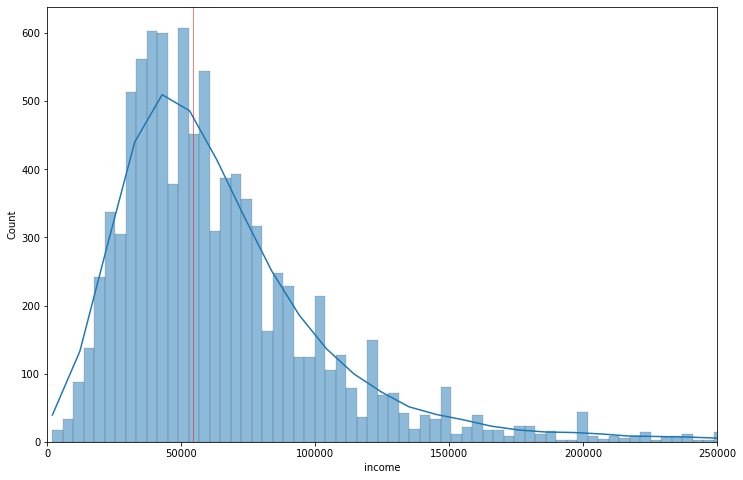

In [12]:
#Visualize as original data. Limit graph to $250k to make it look OK
df["income"] = np.exp(df["log.annual.inc"])
sns.histplot(df["income"], kde=True)
plt.xlim(0,250000)

convMed = np.exp(np.mean(means))
thinkplot.axvline(convMed, color="red")
print("Estimated Population Mean:", convMed)

## Discreet Distributions

Until now, we've mainly dealt with distributions like the normal, lognormal, and exponential - distributions that are continuous, or they may take on any value. We also have distributions that measure discreet things - things which may only take on specific values. Two examples below are goals in sports (hockey, soccer, etc...) or votes in an election - each of these things are counted via whole numbers. 

As we mentioned before, no matter the disribution we create, the process is pretty much the same. (I found this image online, and I think it is a good illustration. This is over-the-top detailed for us, it shows two standard deviations for normal on each side of the curve, but it does a reasonable job of illustrating what we need.)

![Distributions](images/distributions.png "Distributions")

The mechanics of using these discreet distributions doesn't differ all that much from the continous ones. 

### Discreet Distributions in Practice

#### Goals in a Game - Poisson

We can approximate the expected number of goals in a game by using a Poisson distribution. It is use to model things that happen periodically, but semi-randomly - like customrers walking into a store, phone calls to a call center, or goals in some game. 

![Poisson](images/poisson.png "Poisson")

<br>
Below are a couple of examples - the input is the rate - in this case goals per game. It could be "calls per hour" or similar....

In [13]:
#Print a few
ss.poisson(5).rvs(5)

array([4, 6, 6, 6, 5])

<AxesSubplot:ylabel='Density'>

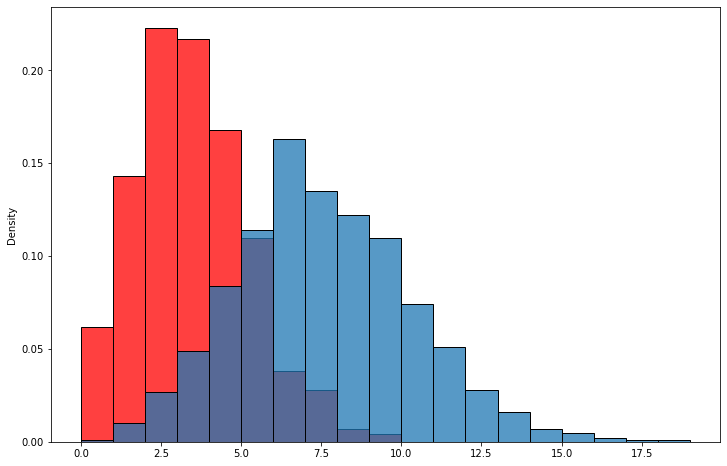

In [14]:
#Example poisson distributions
dist = ss.poisson(3)
dist2 = ss.poisson(7)

sns.histplot(dist.rvs(1000), binwidth=1, stat="density", color="red")
sns.histplot(dist2.rvs(1000), binwidth=1, stat="density")

<h2>Application - Forecast Games</h2>

We can apply this to do a simple estimation of the Battle of Alberta. 

<h3>Load some data</h3>

We can load some data on hockey! This came from hockey reference - it includes the goals per game for each time. Most goals wins, so we'll use that to create a model. 

<b>Note:</b> We are using a function to open Excel here, not a csv. Pandas probably has something to load whatever type of file you have, it just may require a different function or a different set of paramaters. 

In [15]:
#Load and preview data
hock = pd.read_excel("data/sportsref_download.xlsx", sheet_name="Worksheet", engine="openpyxl", header=1)
hock.sample(10)

,Rk,Unnamed: 1,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
25,26.0,Ottawa Senators,26.2,6,2,4,0,4,0.333,15,...,77.78,0,0,11.5,11.5,180,8.3,192,0.901,0
17,18.0,Nashville Predators,27.2,7,3,4,0,6,0.429,20,...,82.61,0,0,8.6,8.3,215,9.3,207,0.903,0
27,28.0,Vegas Golden Knights,28.2,6,2,4,0,4,0.333,13,...,80.00,1,0,9.0,8.8,208,6.3,202,0.901,0
7,8.0,Calgary Flames,28.0,6,4,1,1,9,0.750,21,...,78.95,1,1,9.3,9.0,212,9.9,177,0.915,1
18,19.0,Boston Bruins,28.0,4,3,1,0,6,0.750,14,...,85.71,0,0,9.3,6.8,140,10.0,115,0.904,0
4,5.0,Minnesota Wild,29.4,6,5,1,0,10,0.833,20,...,69.23,0,0,13.3,12.0,218,9.2,167,0.892,0
1,2.0,Carolina Hurricanes,27.9,5,5,0,0,10,1.000,22,...,90.00,0,0,8.0,8.0,175,12.6,149,0.946,0
26,27.0,Colorado Avalanche,27.4,6,2,4,0,4,0.333,15,...,84.21,1,1,11.8,12.3,180,8.3,201,0.886,0
22,23.0,Philadelphia Flyers,28.5,4,2,1,1,5,0.625,18,...,81.25,1,1,16.0,16.0,116,15.5,134,0.910,0
11,12.0,Pittsburgh Penguins,28.2,6,3,1,2,8,0.667,24,...,93.33,0,0,8.0,10.0,198,12.1,176,0.909,0


In [16]:
#Rename column for teams
hock = hock.rename(columns={'Unnamed: 1':"Team"})

In [17]:
#Find the GOALS PER GAME column - It will be very close to GF/G, but we need to be sure!!
hock.columns

Index(['Rk', 'Team', 'AvAge', 'GP', 'W', 'L', 'OL', 'PTS', 'PTS%', 'GF', 'GA',
       'SOW', 'SOL', 'SRS', 'SOS', 'GF/G', 'GA/G', 'PP', 'PPO', 'PP%', 'PPA',
       'PPOA', 'PK%', 'SH', 'SHA', 'PIM/G', 'oPIM/G', 'S', 'S%', 'SA', 'SV%',
       'SO'],
      dtype='object')

In [18]:
#Get Goals per game for the teams playing.
Oil = hock[hock["Team"]=="Edmonton Oilers"]
gfOil = Oil["GF/G"]
print("Oilers Goals per Game:", gfOil)
Fla = hock[hock["Team"]=="Calgary Flames"]
gfFla = Fla["GF/G"]
print("Falmes Goals per Game:", gfFla)

Oilers Goals per Game: 2    4.6
Name: GF/G, dtype: float64
Falmes Goals per Game: 7    3.5
Name: GF/G, dtype: float64


##### Simulate one Game

Simulate one game - take the goals per game, and generate one prediction of an outcome in terms of goals. 

In [20]:
def SimGame(lam):
    dist = ss.poisson(lam)
    score = dist.rvs(1)
    return score[0]

In [21]:
SimGame(gfOil), SimGame(gfFla)

(7, 2)

##### Simulate Many Games

Simulate a bunch of games, and check for bias in our estimator. 

In [22]:
def estimateGame(lam=2., m=1000):
    estimates = []
    for i in range(m):
        L = SimGame(lam)
        estimates.append(L)

    print('Goal Distribution:')
    print('rmse Goals:', RMSE(estimates, lam))
    print('mean error Goals:', MeanError(estimates, lam))
    
    pmf = thinkstats2.Pmf(estimates)
    thinkplot.Hist(pmf)
    thinkplot.Config(xlabel='Goals scored', ylabel='PMF')

Goal Distribution:
rmse Goals: 2.144471962978299
mean error Goals: 0.013200000000000342


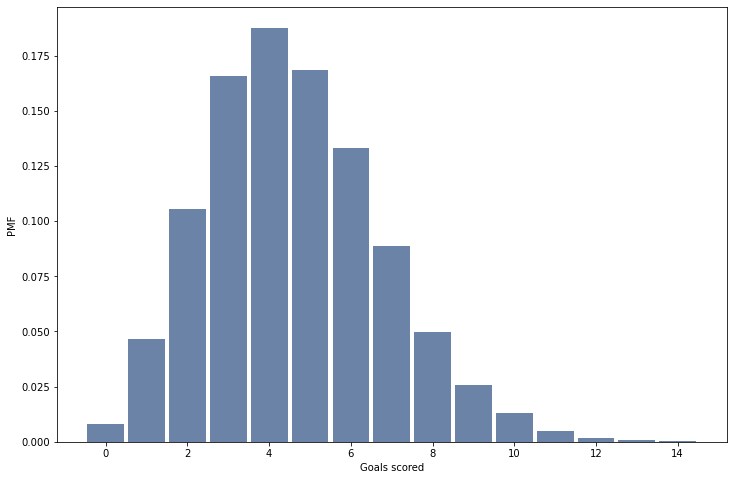

In [23]:
estimateGame(gfOil, 10000)

##### Create Winners

We can predict how many goals each team is to score in the simulated games, then see who scored the most. 

In [24]:
#Estimate a bunch of games, count how many one team wins vs the other. 
def estimateMatch(team1=1, team2=1, m=1000):
    team1Wins = []
    ties = []
    for i in range(m):
        goal1 = SimGame(team1)
        goal2 = SimGame(team2)
        team1Wins.append(int(goal1>goal2))
        ties.append(int(goal1 == goal2))
    return team1Wins, ties

In [26]:
# Print results
oil_win, oil_ties = estimateMatch(gfOil,gfFla,1000)
np.mean(oil_win), np.mean(oil_ties)

(0.598, 0.14)

### Exercise - Try Some Other Teams!

<b>Note:</b> this model is a simplification of the real world, probably too much of one in this case. We can try a more realistic scenario by grabbing some odds from the upcomming week's NFL gambling lines, between the Baltimore Ravens and the Tampa Bay Bradys. 

![lines](images/lines.png "Lines")

This means that the bookmakers have estimated two things:
<ul>
<li> Baltimore is expected to score 1.5 more points than the chump deflator Tom Brady. 
<li> The total number of points scored between the two teams is expected to be 45 points. 
</ul>

<b>What is the probability that Baltimore wins and destroys Brady's dreams like his marriage? </b>

![Brady](images/brady.png "Brady")

##### Generate Expected Points 

We can transform, with a bit of algebra, the projected total and the spread (the +/-) part into an expectation for the number of points each team will score in this game. This expectation takes the place of the previous expectation - the average. 

In [31]:
#Get points per game for the teams playing.
ppgBal = (45/2 + 1.5/2)
ppgTb = (45/2 - 1.5/2)
ppgBal, ppgTb

(23.25, 21.75)

In [30]:
# Project Winners
bal_win, bal_ties = estimateMatch(ppgBal,ppgTb,10000)
np.mean(bal_win), np.mean(bal_ties)

(0.6453, 0.0529)

##### How Could this Model be Better

Our point calculations are naive - we only based them on the raw expected total. For real odds, the bookmakers don't just consider a simple calculation of "how many points", they factor in different scenarios, matchups, injuries, weather, etc... to project who should win. In short, their internal models that are used to generate this are larger - involving more inputs, in an attempt to more thoroughly capture what impacts the outcome of a game. As well, these lines are not set to predict the exact outcome, they're set to balance betting. The bookies make money from the "vig" or basically a commission that is built into each bet; the -110 odds on each side of the "spread" bets show this - winning each pays back approximately 91% of the money, they pocket the rest. The actual lines also intend to balance the amount of money spent on each side of each bet, so they can max that vig without risking paying out massive losses. For many/most bets the true line is good, but sometimes popular teams have excessive betting, so games with the Lakers, Coyboys, and Yankees actually tend to get worse odds since their massive legion of fans will bet on them no matter what, and the bookie is incentivising bets on the other side to balance the interest. 

## Polling - Celebrate the Downfall of Democracy! 

Suppose we are trying to estimate who would win the previous presidental election in the US - in Arizona. 

<b>Note:</b> Estimating the overall win would require projecting each state individually (and dealing with Nebraska and Maine), then projecting the total electoral college votes, since in a presidential election they are effectively separate elections. Same deal, more complex model. Canada is also more complex, since you'd need to project each house seat individually in 4ish way race, then project the distribution of seats, etc... same idea, way more complex scenario. In each of these scenarios winning the most votes doesn't translate into the overall win - winning the most votes, the most times, in multiple smaller elections translates into an overall win. 

In real applications there's also an expectation of correlation between different elections - e.g. it is unlikely for the NDP to win all provincial ridings in west Edmonton, and lose all those in east Edmonton - there is some expected correlation that factors into overall predictions. Voter turnout also is factored in - lower turnouts tend to correspond to more conservative winners - hence the voter supression. There's also the expected sample bias, I'm an old millenial without a land line, and I don't know of any of my social circle who has ever been part of a political poll; the polling organizations know they aren't getting a perfectly representative samples so they build in corrections to their projections to correct for that. Actual polling organizations have factors like these, and others, built into their actual predictions, and this is an example of where their knowledge and skills differentiate their predictions. 

Having no idea how polls work has been one illustration of stats impacting the real world recently. Polls can of course "be wrong" and certain polling organizations generate biased projections, but much more often they are predicting things with a large amount of uncertainty and the less likely thing just happens. Even a poll that says something has an ~97% likelihood of happening is saying that the opposite will happen about one out of every 36 times - unlikely yes, but hardly a total shock - equivalent to rolling snake eyes (two dice, both ones) in a game of craps, which does happen, all the time, just ask Vegas. Legitimate polling organizations publish their confidence intervals and some sampling data at a minimum, and may share some of their interal modelling assumptions, though that is part of what makes them 'better' than their competitors, so they may not give it all. Check this document: [Polling Methodology](guides/polling_report.pdf) the Methodology section towards the end offers a good explaination of how they went about their work in executing the poll and processing the data. Media reports tend to be a very, very short summary of the real results - often to the point of removing needed context. 

<b>What we have here is applicable for one specific election, such as an MP/Congressman race or a state-wide race like governor or elctoral college in the states. Full elections require the above complexity. </b>

### First - Establish probability an individual vote goes for Biden or Trump.

From 538: https://projects.fivethirtyeight.com/polls/president-general/arizona/ we can estimate basssed on all the previous polls that a person is approximately 49% likely to vote Biden, and 46% likely to vote Trump. 

Note: What 538 does to get these numbers involves some estimation already. They take multiple polls and attempt to combine them to make as accurate an estimate as possible. They try to correct for polling companies that historically skew Dem, or skew Rep, or tend to be more/less accurate. We could do this with one poll, it would be the same. 

Because we know (from experience) that only one of these two will actually win, we can try to isolate the share of votes of people who vote for one of these two - 3rd party votes are irrelevant. In reality, one of the things that pollsters will do is try to estimate the number of people who poll that they will vote 3rd party, then end up voting for Trump/Biden. This is an estimate they make based on past data, and domain knowledge. E.g. if we estimated that the share of 3rd party poll responses that voted T/B was skewed 2:1 towards Trump (e.g. libritarians voting Republican), we would add an adjustment here based on that knowledge. Maybe we'd add 1% to Biden's vote probability, and 2% to Trump's. This is something that really is an assumption though. These adjustments based on assumed human actions is what makes a really skilled pollster more accurate - they all know how to do the math. 

In [32]:
#How likely is it for someone to vote Trump and Biden?
probT = .46/(.49+.46)
print("Trump Prob:", probT)

probB = .49/(.49+.46)
print("Biden Prob:", probB)

Trump Prob: 0.48421052631578954
Biden Prob: 0.5157894736842106


So, of the votes that will matter, about 51.5% go Biden, 48.5% go Trump. How does this translate to a person making a vote. For each person, we can make a function to basically get one response. 

This person will return one vote. It will be either a vote for Trump or for Biden. That decision will be random, but it will be set with a likelihood that we calculated before - apx 51.5% of the total voters will vote Biden, as the number of votes we collect gets large. 

Note: for the example, we'll use a vote for Biden to be True/1. A vote for Trump is False/0. This is arbitrary. 

Below we have a function to generate a prediciton using a BINOMIAL distribution - it is either 1 or 0. (A 1 sample binomial dist is also called a Bernouli)

In [33]:
#Generate one vote, with a likelihood supplied as an argument. 
def oneVote(probCalc):
    vote = np.random.binomial(n=1, p=probCalc)
    return vote

In [34]:
#Get one vote, is it Biden or not?
#Run the cell a bunch of times to repeat. 
oneVote(probB)

0

OK, now we have our fake voter. One vote isn't good enough, we need to sample a bunch of people. 

Below, generate a list of n predicted voters. Then check the number that voted Biden. 

In [35]:
#Get an arbitrary number of simulated votes
def getSample(voteProb, n=1000):
    vote_list = []
    for i in range(n):
        vote_list.append(oneVote(voteProb))
    return vote_list

In [36]:
#Get a bunch of votes, print the percentage that are Biden. 
#Try changing n and see what happens. 
tmp = getSample(probB, 5000)
np.mean(tmp)

0.5084

#### Do Some Simulating

That allows us to make one simulation. Congrats - that thing above is one simulated election. We should take a bunch though, and average their results together. 

We can also plot some examples to see what a difference the sample size makes. 

In [37]:
def getSamples(voteProb, n=1000, samples=100, ciLow=2.5, ciHi=97.5):
    meanList = []
    for i in range(samples):
        meanList.append(np.mean(getSample(voteProb, n)))
    muList = [voteProb] * samples
    cdf = thinkstats2.Cdf(meanList) #Make a CDF of the means of the analytical dist's
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi) #5th, 95th percentiles. 
    stderr = mean_squared_error(meanList, muList, squared=False)
    return meanList, stderr, cdf, ci

In [38]:
getSamples(probB, 1000, 5)

([0.46, 0.531, 0.545, 0.502, 0.487],
 0.03229880403950389,
 Cdf([0.46  0.487 0.502 0.531 0.545], [0.2 0.4 0.6 0.8 1. ]),
 (0.46, 0.545))

##### Sample Size Check

Obviously, the more people we've surveyed, the more we should be able to trus our projections, or in other words, the larger our sample size is, the less our projection should waiver. 

All of these graphs have a fixed x-axis, the "tigher" the projections (probability of a Biden win) are, the more confident we are in that prediction. Or, the more likely "that thing" is to happen, and the less likely some "far away thing" is to happen. 

Error: 0.17877313499240832
Error: 0.044798873402929956
Error: 0.013134851401125183
Error: 0.0052390422249589605
Error: 0.0016458036472888756


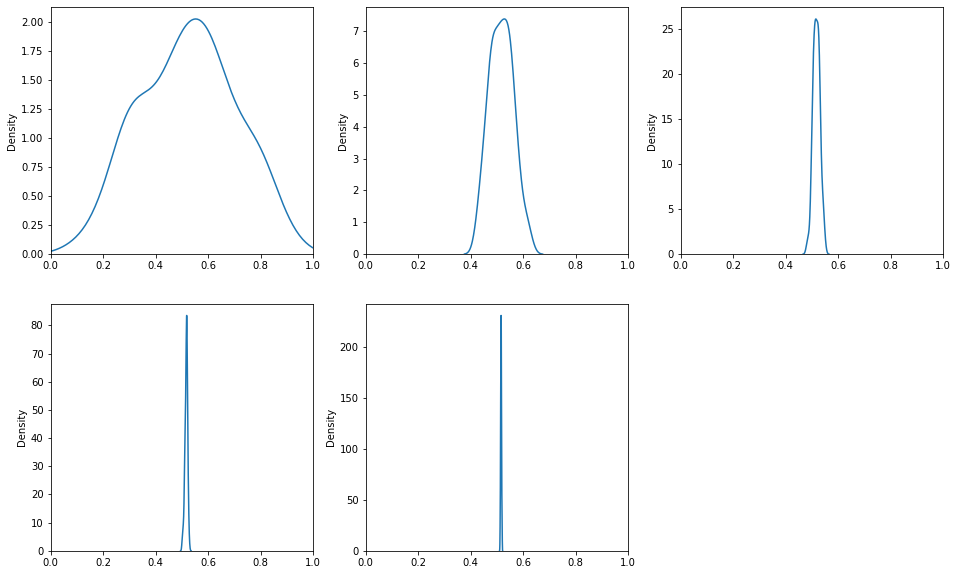

In [39]:
#Print a grid of differnet n values

countHist = 5
nVals = [10,100,1000,10000,100000,1000000]
thinkplot.PrePlot(6,rows=2,cols=3)
samples = 100

for i in range(countHist):
    tmpH, err, cdf, ci = getSamples(probB, nVals[i], samples)
    thinkplot.SubPlot(i+1)
    sns.kdeplot(tmpH).set(xlim=(0,1))
    print("Error:", err)
thinkplot.Config()

Error: 0.16913663771065832
Error: 0.03947407017355168
Error: 0.0139622839808256
Error: 0.005085061740882532
Error: 0.0016520344118876415


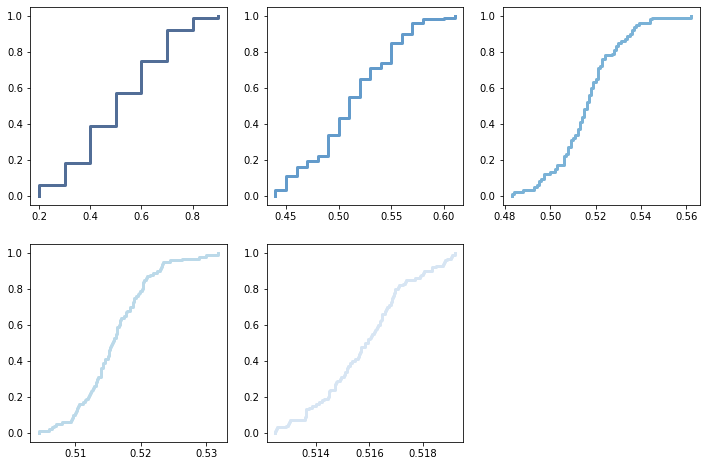

In [40]:
#And the CDFs
from matplotlib.pyplot import xlim


for i in range(countHist):
    tmpH, err, cdf, ci = getSamples(probB, nVals[i], samples)
    thinkplot.SubPlot(i+1)
    thinkplot.Cdf(cdf)
    print("Error:", err)
thinkplot.Config()

Above are multiple executions, with multiple n values. What we should see is that as we get larger and larger n values - the number of 'surveys' taken, we should get closer and closer to a normal curve centered around the expected percentage of votes for Biden = 51.5%. 

### Predict the Winner!!!!

Now we can calculate our projections!

We don't really want to know what percentage of votes Biden is going to get, we want to know how likely he is to win. What we can do below is run some simulations, and for each one see if Biden wins, or if he looses, and then count them up. In each simulation, one candidate will get the most votes, and be declared the winner. 

The three lines below show us the scenarios at each end of the error - the worst and best case expected scenarios. 

0.779


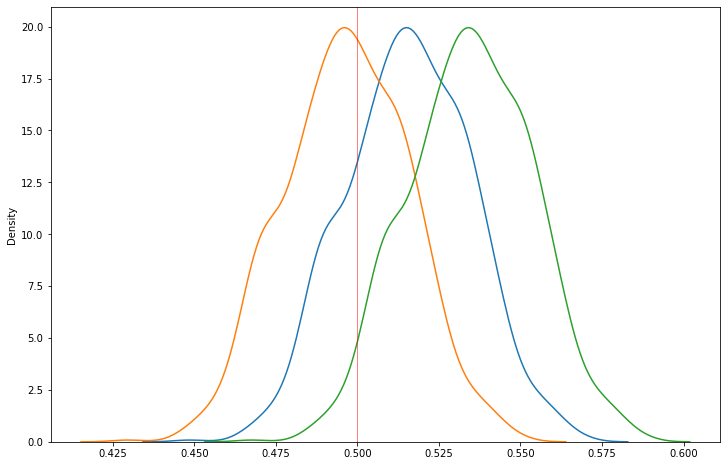

In [41]:
#Run a bunch of trials and count how many Biden wins in. 
trials = 1000
means, err, cdfFin, ciFin = getSamples(probB, n=700, samples=trials)
lowest = means - err
highest = means + err
bWins = 0 
for i in range(len(means)):
    if means[i] > .5000:
        bWins = bWins + 1
print(bWins/trials)

sns.kdeplot(means)
sns.kdeplot(lowest)
sns.kdeplot(highest)
thinkplot.axvline(.5, color="red")

### Final Projection of Winner

Fraction of Scenarios where Biden wins is 77.9% 
We are 95 percent confident that Biden will get between 48.0% and 55.3% percent of the vote


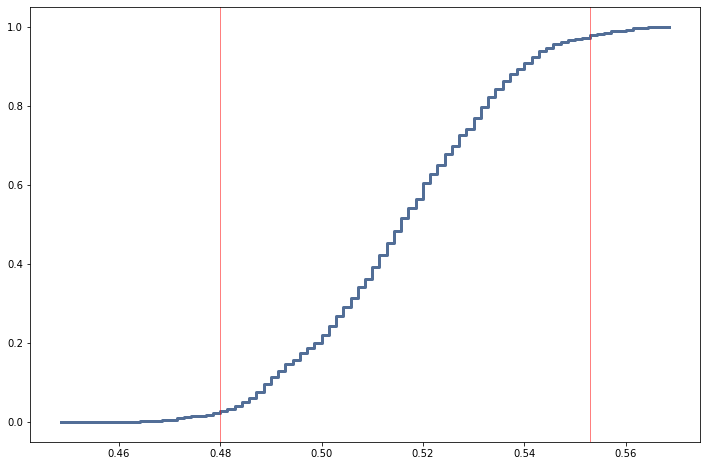

In [42]:
thinkplot.Cdf(cdfFin)
thinkplot.axvline(ciFin[0], color="red")
thinkplot.axvline(ciFin[1], color="red")
print("Fraction of Scenarios where Biden wins is %.1f%% " % ((1-cdfFin.Prob(.50))*100))
print("We are 95 percent confident that Biden will get between %.1f%% and %.1f%% percent of the vote" % (ciFin[0]*100, ciFin[1]*100))

##### Results

So, roughly a 4/5 chance Biden wins. The alternative is much less likely, but still very possible. 

![Biden](images/biden.jpeg "Biden")

## Exercise - Election

There's going to be an election for the president of your class. There are 3 candidates, and the latest pre-election polling results by the school newspaper were:
<ul>
<li> Tricky Nicky - 38 votes
<li> Crazy Jimmy - 34 votes
<li> Silly Willie - 1 vote
</ul>

You feel that the polls are plausible, based on your subjective judgement of the feelings before the election. You want to embarrass those school newspaper nerds and make a more accurate prediction. <b>What is the probability of each candidate winning the election? And what is the 90% CI of Jimmy winning?</b>

In [43]:
# Calculate vote probability
totalVotes = 38+34+1
#We ignorin Willie
tnProb = 38/(totalVotes-1)
cjProb = 34/(totalVotes-1)

<b>I will label Jimmy winning as 1. So this is a calculation of the probability that Jimmy wins.<b>

In [50]:
#Run a bunch of trials and count how many jimmy wins in. 
jWinMeans, err, cdfFinj, ciFinj = getSamples(cjProb, n=totalVotes, samples=1000, ciLow=5, ciHi=95)

#### CDF For Win Totals

0.779


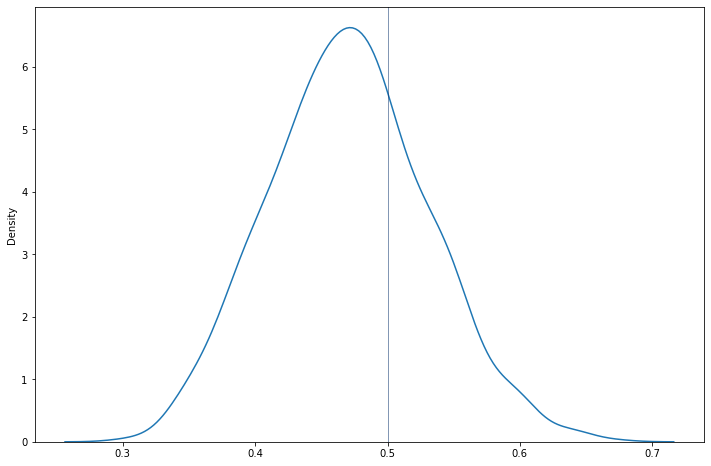

Fraction of Scenarios where Jimmy wins is 29.5% 
We are 90 percent confident that Jimmy will get between 37.0% and 57.5% percent of the vote


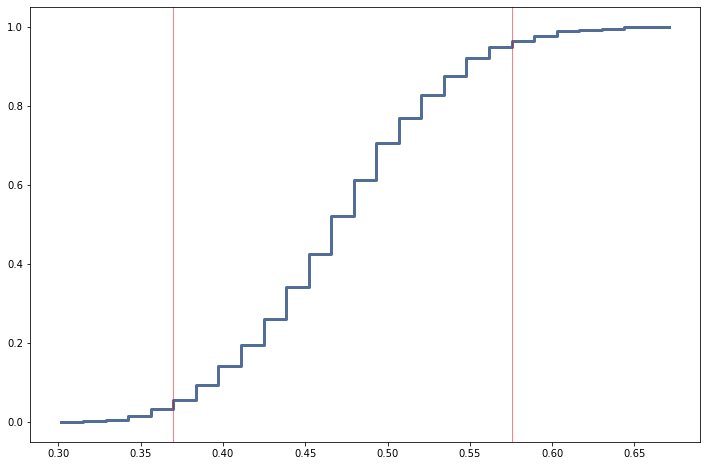

In [52]:
# Calculate final win predictions
jWins = 0 
for i in range(len(means)):
    if means[i] > .5000:
        jWins = jWins + 1
print(jWins/1000)
sns.kdeplot(jWinMeans)
thinkplot.axvline(.50)
plt.show()

thinkplot.Cdf(cdfFinj)
thinkplot.axvline(ciFinj[0], color="red")
thinkplot.axvline(ciFinj[1], color="red")
print("Fraction of Scenarios where Jimmy wins is %.1f%% " % ((1-cdfFinj.Prob(.50))*100))
print("We are 90 percent confident that Jimmy will get between %.1f%% and %.1f%% percent of the vote" % (ciFinj[0]*100, ciFinj[1]*100))
